In [235]:
import numpy as np
import pandas as pd
import glob
import math
import os 
from random import shuffle
import cv2
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

print(tf.__version__)
print(tf.keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  

2.5.0
2.5.0
Num GPUs Available:  0


In [236]:
sampling_rate = 1024
gesture_size = 1536 #each gesture records 1.5 seconds
time_ms = (1/sampling_rate) * 1000 #sampling time in ms
nfft = 64 #window length -> 256 samples - 125 ms and 128 samples - 62.5ms
overlap = 58 #87.5% overlapping [128 - 112ms and 256 - 224ms]
zp =  0
T_sample = 1.5 #in seconds

train_data = []
test_data = []

gesture_mapping = {'double_tap': 4,
                   'tick': 3,
                   'swipe': 2,
                   'up_to_down': 1,
                   'nothing': 0
                   }

In [237]:
path = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/ml_radar/Radar/Data/Images/1024_64nfft/Grayscale_rfft/Subject1'     
#path = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/radar/1024_64nfft/Grayscale_rfft/Subject1'              
image_paths = os.listdir(path)
shuffle(image_paths)
#print(image_paths)

path2 = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/ml_radar/Radar/Data/Images/1024_64nfft/Grayscale_rfft/Subject2'    
#path2 = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/radar/1024_64nfft/Grayscale_rfft/Subject2'               
image_paths2 = os.listdir(path2)
shuffle(image_paths2)

path1 = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/ml_radar/Radar/Data/Images/1024_64nfft/Grayscale_rfft/Test'   
#path1 = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/radar/1024_64nfft/Grayscale_rfft/Test'                
image_paths1 = os.listdir(path1)
shuffle(image_paths1)

img_path1 = os.path.join(path, 'double_tap-11_rfft.png')
image1 = cv2.imread(img_path1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
print(image1.shape)
print(type(image1[0][0]))

IMAGE_HEIGHT = int(image1.shape[0])
IMAGE_WIDTH = int(image1.shape[1]) #47
print(IMAGE_HEIGHT)
print(IMAGE_WIDTH)

(32, 47)
<class 'numpy.uint8'>
32
47


In [238]:
def label_int(word_label):
    label = gesture_mapping[word_label]
    label_arr = np.zeros(5)
    label_arr[label] = 1
    return label_arr

In [239]:
for img in image_paths:
    word_label = img.split('-')[0]
    label = label_int(word_label)
    img_path = os.path.join(path, img)
    #image = PIL.Image.open(img_path)
    image = cv2.imread(img_path)
    #image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = image.astype('float') / 255.0
    train_data.append([image, label])

for img2 in image_paths2:
    word_label2 = img2.split('-')[0]
    label2 = label_int(word_label2)
    img_path2 = os.path.join(path2, img2)
    #image = PIL.Image.open(img_path)
    image2 = cv2.imread(img_path2)
    #image2 = cv2.resize(image2, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    #image = image.astype('float') / 255.0
    train_data.append([image2, label2])

for img_t in image_paths1:
    word_label_t = img_t.split('-')[0]
    label_t = label_int(word_label_t)
    img_path1 = os.path.join(path1, img_t)
    #image_t = PIL.Image.open(img_path1)
    image_t = cv2.imread(img_path1)
    #image_t = cv2.resize(image_t, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image_t = cv2.cvtColor(image_t, cv2.COLOR_BGR2GRAY)
    #image_t = image_t.astype('float') / 255.0
    test_data.append([image_t, label_t])
       

In [240]:
#parameters
data_size = len(train_data)+len(test_data)
input_shape = image.shape  
split_ratio = 0.8
train_size = int(data_size * split_ratio)
NUM_CLASSES = 5
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-4
MOMENTUM = 0.8
DECAY = 1e-06

#print(train_data[0])
print("total number of images = " + str(data_size))
print("input image shape = " + str(input_shape))

#train_data = data[:train_size]
train_images = np.array([i[0] for i in train_data])
#.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
train_labels = np.array([i[1] for i in train_data])

#test_data = data[train_size:]
X_test = np.array([i[0] for i in test_data])
#.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
Y_test = np.array([i[1] for i in test_data])

X_train, X_val, Y_train, Y_val = train_test_split(train_images, 
                                                  train_labels, 
                                                  test_size=0.15, 
                                                  stratify=np.array(train_labels), 
                                                  random_state=42)


print ("number of training + validation examples = " + str(train_images.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


total number of images = 2000
input image shape = (32, 47)
number of training + validation examples = 1900
number of test examples = 100
X_train shape: (1615, 32, 47)
Y_train shape: (1615, 5)
X_val shape: (285, 32, 47)
Y_val shape: (285, 5)
X_test shape: (100, 32, 47)
Y_test shape: (100, 5)


[0. 0. 0. 0. 1.]


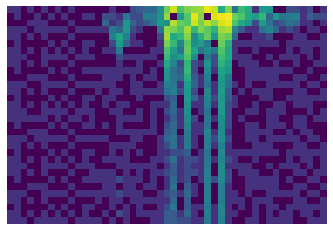

In [241]:
#plt.imshow(data[15][0])
#plt.axis('off')
#print(data[15][1])


plt.imshow(X_train[1])
plt.axis('off')
print(Y_train[1])
np.set_printoptions(threshold=np.inf)
#print(X_train[1].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH))


In [242]:


def get_model():
    model = tf.keras.Sequential()#Sequential() #4-6-4-6 #4-6-8-4 #4-8-6-4 #4-6-6-4 

    # Input Layer
    model.add(Activation(None, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(4, kernel_size = (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(6, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(4, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2)) 
    model.add(Dense(5, activation = 'softmax', kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l2(0.0001)))

    #activation = 'softmax', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)
    sgd = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
    adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ['accuracy'])
    #print('model prepared...')
    return model

In [243]:
model = get_model()

In [244]:
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_val,Y_val))

Epoch 1/2
51/51 [==============================] - 2s 25ms/step - loss: 1.5198 - accuracy: 0.3659 - val_loss: 1.6192 - val_accuracy: 0.2491
Epoch 2/2
51/51 [==============================] - 1s 21ms/step - loss: 1.0258 - accuracy: 0.6762 - val_loss: 1.4722 - val_accuracy: 0.3368


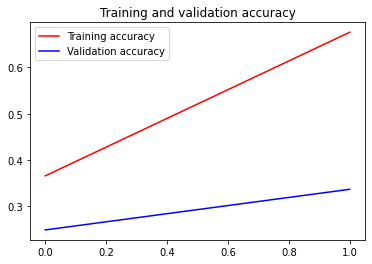

<Figure size 432x288 with 0 Axes>

In [245]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [246]:
predictions = model.evaluate(X_test, Y_test)
print ("Loss = " + str(predictions[0]))
#print ("Test Accuracy = " + str(predictions[1]))
print("Model has an accuracy of {0:.2f}%".format(predictions[1] * 100))

4/4 [==============================] - 0s 8ms/step - loss: 1.4996 - accuracy: 0.4000
Loss = 1.4995859861373901
Model has an accuracy of 40.00%


In [247]:
from sklearn.metrics import confusion_matrix

tt= model.predict(X_test)
cm=confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(tt,axis=1))
print(cm)

[[20  0  0  0  0]
 [ 3  0 16  1  0]
 [ 6  0 14  0  0]
 [16  0  4  0  0]
 [ 0  0  8  6  6]]


(32, 47)
[[0.19357474 0.09252723 0.19843073 0.22408181 0.29138553]]
[0. 0. 0. 0. 1.]


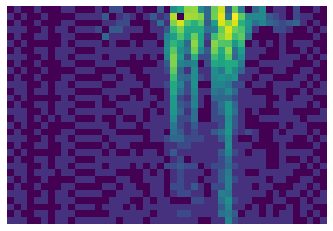

In [248]:
index = 49
print(X_test[index].shape)
xi = X_test[index].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH)
#print(xi.shape)
#print(X_test.shape)

tt= model.predict(xi)
print(tt)

plt.axis('off')
plt.imshow(cv2.resize(X_test[index], (IMAGE_WIDTH, IMAGE_HEIGHT)))
print(Y_test[index])


In [249]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_14 (Activation)   (None, 32, 47, 1)         0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 32, 47, 1)         4         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 30, 45, 4)         40        
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 15, 22, 4)         0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 15, 22, 4)         16        
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 13, 20, 6)         222       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 6, 10, 6)        

In [250]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp4_g2eoxv/assets


INFO:tensorflow:Assets written to: /tmp/tmp4_g2eoxv/assets


In [251]:
def representative_dataset_gen():
  for image in X_test:
    image = image.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH,1)
    image = image.astype('float32')
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
#converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

#open("radar_gesture.tflite", "wb").write(tflite_model)

#import os
#basic_model_size = os.path.getsize("radar_gesture.tflite")
#print("Model is %d bytes" % basic_model_size)

#open("radar_gesture.tflite", "wb").write(tflite_model)
#!xxd -i radar_gesture.tflite > radar_gesture.cc

INFO:tensorflow:Assets written to: /tmp/tmpeq6ol05d/assets


INFO:tensorflow:Assets written to: /tmp/tmpeq6ol05d/assets


In [252]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [253]:
import pathlib

tflite_models_dir = pathlib.Path("/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/data/radar_gesture")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"radar_gesture.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
#tflite_model_quant_file = tflite_models_dir/"radar_gesture.tflite"
#tflite_model_quant_file.write_bytes(tflite_model_quant)

13792

In [254]:
Y_test1 = []
for img_t in image_paths1:
    word_label_t = img_t.split('-')[0]
    label = gesture_mapping[word_label_t]
    Y_test1.append(label)

In [255]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  #global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = X_test[test_image_index].reshape( IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    test_label = Y_test1[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.int8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [256]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  #global X_test
  #global Y_test

  test_image_indices = range(X_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(Y_test1== predictions) * 100) / len(X_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(X_test)))

In [257]:
evaluate_model(tflite_model_file, model_type="Float")
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Float model accuracy is 40.0000% (Number of test samples=100)


NameError: name 'tflite_model_quant_file' is not defined

[0]


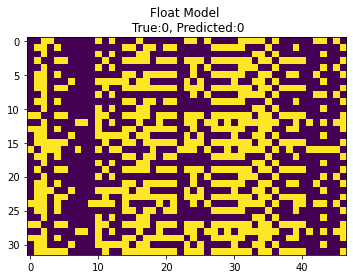

In [ ]:
import matplotlib.pylab as plt

   
#print(Y_test1)    
# Change this to test a different image
test_image_index = 40

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  print(predictions)
  plt.imshow(X_test[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(Y_test1[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)


test_model(tflite_model_file, test_image_index, model_type="Float")

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(loss ='categorical_crossentropy', optimizer="adam", metrics = ['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ['accuracy'])

q_aware_model.summary()

#history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_val,Y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 32, 47, 1)         3         
_________________________________________________________________
quant_activation_2 (Quantize (None, 32, 47, 1)         1         
_________________________________________________________________
quant_conv2d_8 (QuantizeWrap (None, 30, 45, 4)         51        
_________________________________________________________________
quant_max_pooling2d_6 (Quant (None, 15, 22, 4)         1         
_________________________________________________________________
quant_conv2d_9 (QuantizeWrap (None, 13, 20, 6)         237       
_________________________________________________________________
quant_max_pooling2d_7 (Quant (None, 6, 10, 6)          1         
_________________________________________________________________
quant_conv2d_10 (QuantizeWra (None, 4, 8, 8)          

In [ ]:
#history = q_aware_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_val,Y_val))


Epoch 1/20


TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: dense_5/ActivityRegularizer/truediv:0

In [ ]:
baseline_model_accuracy = model.evaluate(
    X_test, Y_test, verbose=0)

q_aware_model_accuracy = q_aware_model.evaluate(
   X_test, Y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/venv/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: dense_9/ActivityRegularizer/truediv:0

In [ ]:
import numpy as np

def evaluate_model1(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(X_test):
    test_image = test_image.reshape( IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == Y_test1).mean()
  return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model1(interpreter)


print('Quant TFLite test_accuracy:', test_accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.


Quant TFLite test_accuracy: 0.2
